# Press the Double Arrow above to Begin, then click red pop-up to confirm

In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
display("Loading Allen Transcriptomics Single-Cell RNAseq data, retreived May 2020. Be patient, it's loading!")

"Loading Allen Transcriptomics Single-Cell RNAseq data, retreived May 2020. Be patient, it's loading!"

In [4]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [5]:
%%capture
!pip install dropbox

In [6]:
import matplotlib 
import ipywidgets as widgets
import pandas as pd
import io
import seaborn as sns
import openpyxl
import dropbox
from IPython.display import display
from ipywidgets import interact_manual, interactive,GridspecLayout, AppLayout, Button, Layout

In [7]:
##get data from dropbox
DBX = dropbox.Dropbox('bb3H-rx_L8IAAAAAAAAPdR77ZBO4BYfjelCVEH8kkSj04MX4vx4RrPFfN0cfJ3tm')

_, res = DBX.files_download("/human_means.csv")

with io.BytesIO(res.content) as stream:
    human_means = pd.read_csv(stream, index_col=0)

_, res2 = DBX.files_download("/mouse_medians.csv")
with io.BytesIO(res2.content) as stream:
    meds = pd.read_csv(stream, index_col=0)   
    

# Get all gene and cell type names: HUMAN
human_listOfColumnNames = list(human_means.columns.values)
human_idx = list(human_means.index)
# Get all gene and cell type: MOUSE
mouse_listOfColumnNames = list(meds.columns.values)
idx = list(meds.index)

In [8]:
##define GUI
table_style = {'description_width': 'initial'}
useidx = ('choose species','then genes will appear')
spacer = widgets.Label('')

from threading import Timer

from traitlets import traitlets

class LoadedButton(widgets.Button):
    """A button that can hold a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))
#####################################################        
genes = []
genetitle = widgets.Label('Select Genes')
dropdown =  widgets.Combobox(
    options= idx,
    description='Gene',
    placeholder='Type here',
    layout={'width': '80%'})

def delay():
    gene_button.button_style = ''
    gene_button.disabled = False
    
def choose_gene(change):
    if len(genes)<=7:
        gene_button.button_style = 'success'
        gene_button.disabled = True
        genes.append(dropdown.value)     
        d = Timer(0.5,delay)
        d.start()
    if len(genes)>7:       
        gene_button.button_style = 'warning'
        gene_button.description = "Max Genes Selected"
        gene_button.disabled = True
        
gene_button = widgets.Button(description = 'Enter Gene', button_style = '')
gene_button.on_click(choose_gene)

analysislabel = widgets.Label('Graph Type')        
def on_exp_button_clicked(exp):
    exp.value = "exp"
    venn.disabled = True
    exp.button_style = 'success'
    graphtype = "Exp"


def on_venn_button_clicked(venn):
    venn.value = "venn"
    venn.button_style = 'success'
    exp.disabled = True
    graphtype = "Venn"
    
exp = LoadedButton(description="Expression Level", value="not exp")
exp.on_click(on_exp_button_clicked)         

venn = LoadedButton(description="Venn Diagram", value="not venn")
venn.on_click(on_venn_button_clicked)


choicelabel = widgets.Label('Analyze species:')
msCells = widgets.Button(
    description='Mouse',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    width = '110%')

huCells = widgets.Button(
    description='Human',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    width = '110%')

#####################################################
mscelllabel = widgets.Label('Mouse Cell Clusters:')
msCells_drop =widgets.SelectMultiple(
    options=mouse_listOfColumnNames,
    disabled=True,
    rows=17,
    layout={'width': 'max-content'},
    #style=table_style
) 

hucelllabel = widgets.Label('Human Cell Clusters:')
huCells_drop =widgets.SelectMultiple(
    options=human_listOfColumnNames,
    disabled=True,
    rows=17,
    layout={'width': 'max-content'},
    #style=table_style
) 

def choose_mouse(msCells):
    huCells.disabled = True
    msCells.button_style = 'success'
    msCells_drop.disabled = False
    huCells_drop.disabled = True 
    msCells.value = "mouse"

msCells.on_click(choose_mouse)

def choose_human(huCells):
    huCells.button_style = 'success'
    msCells.disabled = True
    msCells_drop.disabled = True
    huCells_drop.disabled = False
    huCells.value = "human"
    dropdown.options = human_idx

huCells.on_click(choose_human)

msCells = LoadedButton(description="Mouse", value="not mouse")
msCells.on_click(choose_mouse)   

huCells = LoadedButton(description="Human", value="not human")
huCells.on_click(choose_human) 
dropdown.observe(choose_human, 'change')
########################################

excel_label = widgets.Text(
    value='Name',
    placeholder='Type something',
    description='Name Excel:',
    disabled=False
)

go_button = widgets.Button(description = 'Produce Output', 
                           button_style = 'success', 
                            display='flex',
                            flex_flow='column',
                            align_items='stretch')
reset_button = widgets.Button(description = 'Reset Options',
                              button_style = 'warning',
                            display='flex',
                            flex_flow='column',
                            align_items='stretch',
                             width = 'auto')

from ipywidgets import Widget
cells =[]
def on_go_button_clicked(go_button):
    excelname = excel_label.value + ".xlsx"
    if huCells.value == 'human':
        cells.append(huCells_drop.value)
    else:
        cells.append(msCells_drop.value)
    if venn.value == "venn":
        venngraph(genes, excelname)
        
    if exp.value == "exp":
        expgraph(genes,cells,excelname)

def on_reset_button_clicked(reset_button):  
    Widget.close_all()
    
go_button.observe(huCells, 'value')
go_button.observe(venn, 'value')    
go_button.observe(exp, 'value')    
go_button.on_click(on_go_button_clicked)
reset_button.on_click(on_reset_button_clicked)



spacervenn = widgets.VBox([spacer,venn])
specieschoices = widgets.VBox([choicelabel,msCells, mscelllabel, msCells_drop])
spacerhuman = widgets.VBox([spacer, huCells,hucelllabel, huCells_drop])
genesbox = widgets.VBox([genetitle,dropdown, gene_button])
buttons = widgets.HBox([go_button, spacer, reset_button])
graphchoices = widgets.VBox([analysislabel, exp, venn, spacer, spacer, genesbox,spacer, spacer, excel_label, buttons])
graphs2 = widgets.HBox([graphchoices])
####################################################
display("..............")
display("Choose your Species and Graph Type. For Expression level graphs, choose cell types to include. For Venn diagrams, all cell types will be included. Choose genes, pressing Enter after each choice. To produce graphs, press the green Produce Output button.")

'..............'

'Choose your Species and Graph Type. For Expression level graphs, choose cell types to include. For Venn diagrams, all cell types will be included. Choose genes, pressing Enter after each choice. To produce graphs, press the green Produce Output button.'

In [9]:
%matplotlib notebook

def expgraph(genes, cells, excelname): 
    
    if msCells.value == 'mouse':
        bigframe = meds
        cells = msCells_drop.value
    if huCells.value == 'human':
        bigframe = human_means
        cells = huCells_drop.value

    newdf = pd.DataFrame(columns = ['Cells','Genes','Expression'])
    newdf['Cells'] = cells * len(genes)


    genelist=[]
    for i in range(len(genes)):
        genea = [genes[i]]*len(cells)
        genelist.append(genea)
    flat_geneslist = [item for sublist in genelist for item in sublist]
    newdf['Genes'] = flat_geneslist

    expressions =[]
    for i in range(len(genes)*len(cells)):
        value1 = bigframe.loc[newdf['Genes'][i], newdf['Cells'][i]]
        expressions.append(value1)
    newdf['Expression'] = expressions

    if len(newdf['Expression'])>0:
        maxm = max(newdf["Expression"])
    
    writer = pd.ExcelWriter(excelname, engine='openpyxl')
    newdf.to_excel(writer, sheet_name='Sheet1')
    writer.save()
    
    sns.set_palette("colorblind", 10)
    g = sns.catplot(x="Genes", y="Expression", col="Cells",
                    data=newdf, 
                    saturation=1,
                    kind="bar", 
                    ci=None, 
                    aspect=.6, 
                    edgecolor="k", 
                    linewidth=1
                    )


    (g.set_axis_labels("", "Expression")
          .set_xticklabels(genes)
          .set_titles("{col_name}")
          .set(ylim=(0, (maxm + 2)))
          .despine(left=True))  

    for ax in g.axes.ravel():
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
            for p in ax.patches:
                ax.annotate('%.2f' % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 8), 
                textcoords='offset points')


In [10]:
def venngraph(genes, excelname):
        labels_yn = "True"
        from matplotlib_venn import venn2
        from matplotlib_venn import venn3
        from matplotlib import pyplot as plt
     
        if msCells.value == 'mouse':
            venny = meds.loc[genes]
        if huCells.value == 'human':
            venny = human_means.loc[genes]

        venny1 = venny.loc[genes[0]]
        venny1 = venny1[venny1 >= 0.5].index.to_list()

        venny2 = venny.loc[genes[1]]
        venny2 = venny2[venny2 >= 0.5].index.to_list()

        v1only = list(set(venny1) - set(venny2))
        v2only = list(set(venny2) - set(venny1))
        overlap_ab = [value for value in venny1 if value in venny2] 
        
        name1 = str(genes[0]) + " only"
        name2 = str(genes[1]) + " only"
        nameab = str(genes[0]) + " and " + str(genes[1])

        
        if len(genes) == 2:
            if (len(venny1) >= 1) & (len(venny2) >= 1):
                la,lb,lc = len(v1only),len(v2only),len(overlap_ab)
                # now find the max
                max_len = max(la,lb,lc)
                if not max_len == la:
                    v1only.extend(['']*(max_len-la))
                if not max_len == lb:
                    v2only.extend(['']*(max_len-lb))
                if not max_len == lc:
                    overlap_ab.extend(['']*(max_len-lc))
                venn_df = pd.DataFrame({name1:v1only,name2:v2only,nameab:overlap_ab}) 
                writer = pd.ExcelWriter(excelname, engine='openpyxl')
                venn_df.to_excel(writer, sheet_name='Sheet1')
                writer.save()
                
                labels = ["Cells containing " + genes[0],"Cells containing " + genes[1] ]
                    
                v = venn2([set(venny1), set(venny2)], set_labels = (genes[0], genes[1]))
                 

                    #if labels_yn == "True":
                        #v.get_label_by_id('10').set_text('\n'.join(v1only))
                        #v.get_label_by_id('01').set_text('\n'.join(v2only))
                        #v.get_label_by_id('11').set_text('\n'.join(overlap_ab))
                                
            else:
                print("No Overlap: At least one gene is not expressed over a value of 0.5 in any cell types:", 
                      genes[0], ": expressed in ", len(venny1), "cells; ", genes[1], ": expressed in ", len(venny2), "cells. ")
                

        if len(genes) == 3:
            venny3 = meds.loc[genes[2]]
            venny3 = venny3[venny3 >= 0.5].index.to_list()
            if (len(venny1) >= 1) & (len(venny2) >= 1) & (len(venny3) >= 1):
                name3 = str(genes[2]) + " only"
                namebc = str(genes[1]) + " and " + str(genes[2])
                nameac = str(genes[0]) + " and " + str(genes[2])
                nameabc = str(genes[0]) + " and " + str(genes[1])+ " and " + str(genes[2])         
                v3only = list(set(venny1) - set(venny2) - set(venny3))
                overlap_bc = [value for value in venny2 if value in venny3]
                overlap_ac = [value for value in venny1 if value in venny3]
                overlap_abc = [value for value in venny3 if value in overlap_ab]

                la,lb,lc, ld, le, lf, lg  = len(v1only),len(v2only),len(v3only),len(overlap_ab),len(overlap_bc),len(overlap_ac),len(overlap_abc)
                # now find the max
                max_len = max(la,lb,lc,ld, le, lf, lg)
                if not max_len == la:
                    v1only.extend(['']*(max_len-la))
                if not max_len == lb:
                    v2only.extend(['']*(max_len-lb))
                if not max_len == lc:
                    v3only.extend(['']*(max_len-lc))
                if not max_len == ld:
                    overlap_ab.extend(['']*(max_len-ld))
                if not max_len == le:
                    overlap_bc.extend(['']*(max_len-le))
                if not max_len == lf:
                    overlap_ac.extend(['']*(max_len-lf))
                if not max_len == lg:
                    overlap_abc.extend(['']*(max_len-lg))

                venn_df = pd.DataFrame({name1:v1only,name2:v2only,name3:v3only,nameab:overlap_ab,namebc:overlap_bc,
                                                nameac:overlap_ac, nameabc: overlap_abc}) 
                writer = pd.ExcelWriter(excelname, engine='openpyxl')
                venn_df.to_excel(writer, sheet_name='Sheet1')
                writer.save() 
                
                labels = ["Cells containing " + genes[0],"Cells containing " 
                                + genes[1], "Cells containing " +genes[2] ]
                v = venn3([set(venny1), set(venny2), set(venny3)], 
                                set_labels = (genes[0], genes[1], genes[2]))
                        
            else:
                print("No Overlap: At least one gene is not expressed over a value of 0.5 in any cell types:", 
                      genes[0], ": expressed in ", len(venny1), "cells; ", genes[1], ": expressed in ", len(venny2), "cells; ",
                     genes[2], ": expressed in ", len(venny3), "cells.")
        
        plt.show()

GridspecLayout(children=(VBox(children=(Label(value='Analyze species:'), LoadedButton(description='Mouse', sty…

<IPython.core.display.Javascript object>


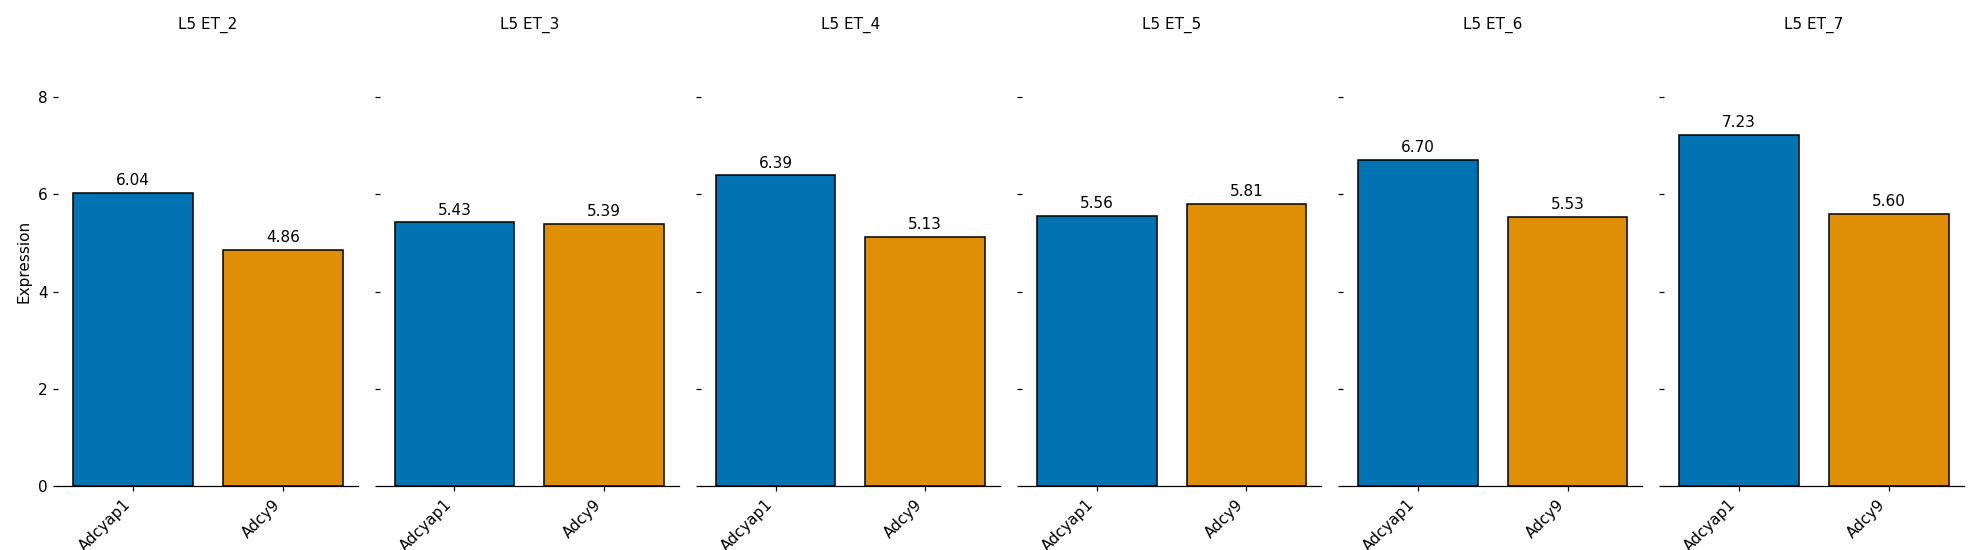

In [11]:
### cell #1

box_layout = widgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px',
        height='auto', width='auto')

grid = GridspecLayout(1, 3)
grid.layout = box_layout
# fill it in with widgets
grid[0,0] = specieschoices
grid[0,1] = spacerhuman
grid[0, 2:] = graphs2
grid